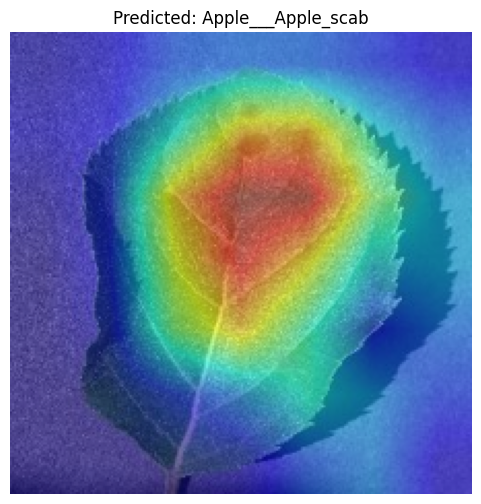

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
import numpy as np

# --- 你的超参 ---
dataset_root = "/workspace/combined_dataset_split2/train"       # 数据集根目录，ImageFolder结构
model_path = "/workspace/se_resnet50.pth"   # 你的训练好的模型权重
image_path = "/workspace/combined_dataset_split2/test/Apple___Apple_scab/0a769a71-052a-4f19-a4d8-b0f0cb75541c___FREC_Scab 3165.JPG"         # 测试图片路径
num_classes = 38                               # 类别数量

# 定义SE模块
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        w = self.pool(x).view(b, c)
        w = self.fc(w).view(b, c, 1, 1)
        return x * w

# 包装 torchvision 自带 Bottleneck 加 SE
class SEBottleneck(nn.Module):
    def __init__(self, bottleneck):
        super(SEBottleneck, self).__init__()
        self.bottleneck = bottleneck
        self.se = SEBlock(bottleneck.conv3.out_channels)

    def forward(self, x):
        out = self.bottleneck(x)
        out = self.se(out)
        return out

# 构建 SE-ResNet50
def build_se_resnet50(num_classes):
    model = models.resnet50(pretrained=False)
    for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
        old_layer = getattr(model, layer_name)
        new_blocks = []
        for block in old_layer:
            new_blocks.append(SEBottleneck(block))
        setattr(model, layer_name, nn.Sequential(*new_blocks))
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# --- Grad-CAM 实现 ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        # 这里用register_full_backward_hook需PyTorch>=1.8，否则用register_backward_hook
        self.target_layer.register_full_backward_hook(backward_hook)
    def generate(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        self.model.zero_grad()
        loss = output[0, target_class]
        loss.backward(retain_graph=True)
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # GAP权重
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam -= cam.min()
        cam /= cam.max() + 1e-8
        return cam

# --- 可视化 Grad-CAM ---
def visualize_gradcam(model, image_path, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(next(model.parameters()).device)
    target_layer = model.layer4[-1]
    gradcam = GradCAM(model, target_layer)
    cam = gradcam.generate(input_tensor)
    cam = cv2.resize(cam, (224, 224))

    original = np.array(image.resize((224, 224)))  # RGB 格式
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # 将 heatmap 转成 RGB
    overlay = cv2.addWeighted(original, 0.5, heatmap, 0.5, 0)

    model.eval()
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    plt.figure(figsize=(6, 6))
    plt.title(f"Predicted: {class_names[pred_class]}")
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

# --- 主流程 ---
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 加载类别名
    train_dataset = datasets.ImageFolder(root=dataset_root)
    class_names = train_dataset.classes
    # 构建模型并加载权重
    model = build_se_resnet50(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    # 执行Grad-CAM可视化
    visualize_gradcam(model, image_path, class_names)


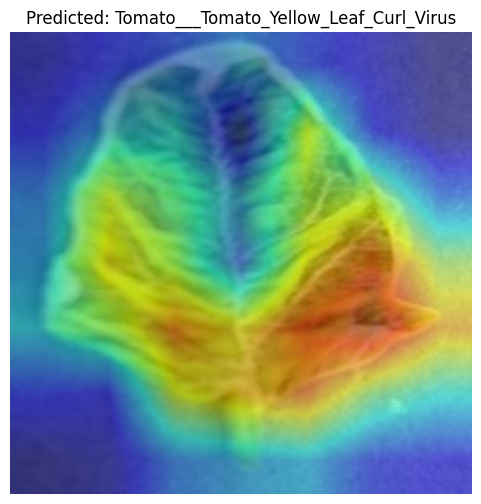

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
import numpy as np

# --- 你的超参 ---
dataset_root = "/workspace/combined_dataset_split2/train"       # 数据集根目录，ImageFolder结构
model_path = "/workspace/se_resnet50.pth"   # 你的训练好的模型权重
image_path = "/workspace/combined_dataset_split2/test/Tomato___Tomato_Yellow_Leaf_Curl_Virus/TomatoYellowCurlVirus6.JPG"         # 测试图片路径
num_classes = 38                               # 类别数量

# 定义SE模块
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        w = self.pool(x).view(b, c)
        w = self.fc(w).view(b, c, 1, 1)
        return x * w

# 包装 torchvision 自带 Bottleneck 加 SE
class SEBottleneck(nn.Module):
    def __init__(self, bottleneck):
        super(SEBottleneck, self).__init__()
        self.bottleneck = bottleneck
        self.se = SEBlock(bottleneck.conv3.out_channels)

    def forward(self, x):
        out = self.bottleneck(x)
        out = self.se(out)
        return out

# 构建 SE-ResNet50
def build_se_resnet50(num_classes):
    model = models.resnet50(pretrained=False)
    for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
        old_layer = getattr(model, layer_name)
        new_blocks = []
        for block in old_layer:
            new_blocks.append(SEBottleneck(block))
        setattr(model, layer_name, nn.Sequential(*new_blocks))
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# --- Grad-CAM 实现 ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        # 这里用register_full_backward_hook需PyTorch>=1.8，否则用register_backward_hook
        self.target_layer.register_full_backward_hook(backward_hook)
    def generate(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        self.model.zero_grad()
        loss = output[0, target_class]
        loss.backward(retain_graph=True)
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # GAP权重
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam -= cam.min()
        cam /= cam.max() + 1e-8
        return cam

# --- 可视化 Grad-CAM ---
def visualize_gradcam(model, image_path, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(next(model.parameters()).device)
    target_layer = model.layer4[-1]
    gradcam = GradCAM(model, target_layer)
    cam = gradcam.generate(input_tensor)
    cam = cv2.resize(cam, (224, 224))

    original = np.array(image.resize((224, 224)))  # RGB 格式
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # 将 heatmap 转成 RGB
    overlay = cv2.addWeighted(original, 0.5, heatmap, 0.5, 0)

    model.eval()
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    plt.figure(figsize=(6, 6))
    plt.title(f"Predicted: {class_names[pred_class]}")
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

# --- 主流程 ---
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 加载类别名
    train_dataset = datasets.ImageFolder(root=dataset_root)
    class_names = train_dataset.classes
    # 构建模型并加载权重
    model = build_se_resnet50(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    # 执行Grad-CAM可视化
    visualize_gradcam(model, image_path, class_names)
